In [6]:
from adjustable_efficient_qsp import *
from adjustable_efficient_non_unitary import *
from qiskit.tools.visualization import *
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

'''
fig = plt.figure()
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    "font.size": 18
})
'''

'\nfig = plt.figure()\nplt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "Computer Modern",\n    "font.size": 18\n})\n'

In [7]:
# Initial state function
def init(x):
    epsilon0 = 1/10
    return np.exp(-(x-0.5)**2*100)*epsilon0

# Generates the list of size n_operators containing the indices of Walsh operators with highest coefficients
def get_max_coeffs(n,n_operators,f):
    walsh_coeffs = {}
    for i in range(2**n):
        walsh_coeffs[i] = abs(walsh_coeff(i,f,2**n))
    w = sorted(walsh_coeffs.items(), key=lambda x:x[1],reverse=True)
    list_operator_to_implement = list(dict(w).keys())[:n_operators]
    return list_operator_to_implement

Text(0.5, 1.0, 'Diffusion equation resolution')

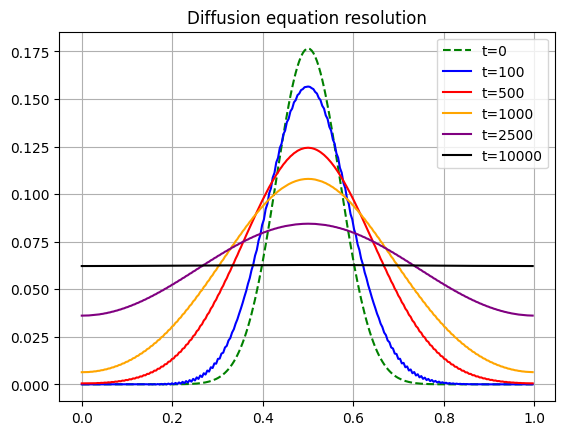

In [8]:
n = 8
n_ancilla_diag = 0
n_ancilla_qsp = 0
gray_code = True

# Number of Walsh operators to implement for the QSP step, max value is 2**n
n_walsh_operators_qsp = 32
list_operator_to_implement_qsp = get_max_coeffs(n,n_walsh_operators_qsp,init)

qsp_walsh = qsp(n,init,n_ancilla_diag,n_ancilla_qsp,list_operator_to_implement_qsp,decomposition='walsh',gray_code=gray_code,swaps=True)

# Number of Walsh operators to implement for the non_unitary step, max value is 2**n
n_walsh_operators_non_unitary = 128

t_list = [100,500,1000,2500,10000]
color_list = ['blue','red','orange','purple','black']

QFT_gate = QFT(n,do_swaps=False)

X = np.array(range(2**n))/(2**n)
plt.plot(X,init(X)/np.linalg.norm(init(X)),marker='',c='g',linestyle='--',label='t=0')
    
for k in range(5):
    t = t_list[k]
    color = color_list[k]
    
    q = QuantumRegister(n,name='q')
    qA = QuantumRegister(1,name='qA')
    qB = QuantumRegister(1,name='qB')
    a = AncillaRegister(n_ancilla_diag,name='a')
    a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
    qc = QuantumCircuit(qB,qA,q,a,a_qsp)
    
    qB_qubits = qc.qubits[:1]
    qA_qubits = qc.qubits[1:2]
    q_qubits = qc.qubits[2:n+2]
    a_qubits = qc.qubits[n+2:n+2+n_ancilla_diag]
    a_qsp_qubits = qc.qubits[n+2+n_ancilla_diag:n+2+n_ancilla_diag+n+2+n_ancilla_qsp]

    # QSP step
    qc.h(q)
    qc.append(qsp_walsh,qA_qubits+q_qubits+a_qubits+a_qsp_qubits)
    
    # Non-unitary step
    
    def d(x):
        kappa = 1
        return np.exp(-t*kappa*np.sin(2*np.pi*(x-0.5))**2)

    list_operator_to_implement_non_unitary = get_max_coeffs(n,n_walsh_operators_non_unitary,d)
    non_unitary_walsh = non_unitary(n,d,n_ancilla_diag,n_ancilla_qsp,list_operator_to_implement_non_unitary,decomposition='walsh',gray_code=gray_code,swaps=False)
    
    qc.append(QFT_gate,q_qubits)
    qc.append(non_unitary_walsh,qB_qubits+q_qubits+a_qubits+a_qsp_qubits)
    qc.append(QFT_gate.inverse(),q_qubits)
    
    dmax = get_dmax(d,2**n) #n_walsh_operators_non_unitary
    state = qi.Statevector.from_instruction(qc)
    state_dict = state.to_dict()
    data = []
    n_bits = len(list(state_dict.keys())[0])
    for i in list(state_dict.keys()):
        if i[n_bits-1] == '0' and i[n_bits-2] == '1':
            data.append(state_dict[i])
    L = np.array(data)
    plt.plot(X,np.real(L)/np.linalg.norm(L),marker='',linestyle='-',c=color,label='t='+str(t))
    
plt.legend()
plt.grid()
plt.title('Diffusion equation resolution')